## 14. Wind Power Prediction Using the Tiny Time Mixers model

**Task Description**:

Use the TTM model to forecast wind power generation, incorporating wind speed and power data. At each time point, forecast the hourly output for the next day. Analyze the forecast errors for the different forecast horizons using the RMSE and MAE. Use the last available year of data as your test set.
Predict the sum of Offshore_Wind and Onshore_Wind (you can choose whether to forecast both and then sum, or forecast the sum directly) from the file: Realised_Supply_Germany.csv

Bonus: Test different feature selection approaches for the weather input.


### Background: Tiny Time Mixers

Tiny Time Mixers (TTM), developed by IBM Research and accepted at NeurIPS 2024, is a time series foundation model with 1-5 million parameters, achieving superior forecasting performance compared to larger models across benchmarks involving financial, energy, weather, and transportation data. TTM replaces transformer attention with Multi-Layer Perceptrons, reducing parameter count by 10-100x and achieving linear computational complexity (O(n)) versus transformers' quadratic (O(n²)). 

The architecture comprises four main components: 
- a TTM Backbone for core processing,
- a Decoder for task-specific adaptation,
- a Forecast Head for predictions
- and an optional Exogenous Mixer for external variables

Key innovations include adaptive patching, which dynamically adjusts patch lengths (K_i) per level to optimize granularity across datasets, and resolution prefix tuning, which concatenates learnable embeddings to input patches for handling multi-frequency data (e.g., minutely to weekly). Instead of standard attention, TTM uses a gated attention mechanism: a softmax after a linear projection produces importance weights, which are then used to scale hidden vectors. The multi-level training strategy employs channel-independent univariate pre-training on 244M to 1B samples, followed by fine-tuning with channel-mixing to capture multivariate dependencies.

![ttm_architecture](images/ttm_architecture.jpg)

<img src="images/gated_attention.png" alt="ttm_ga" width="300">


Ekambaram, V., Jati, A., Dayama, P., Mukherjee, S., Nguyen, N. H., Gifford, W. M., Reddy, C., & Kalagnanam, J. (2024). Tiny Time Mixers (TTMs): Fast Pre-trained Models for Enhanced Zero/Few-Shot Forecasting of Multivariate Time Series. arXiv. https://arxiv.org/abs/2401.03955



### Set up 

In [18]:
# ensure that Jupyter automatically updates imports when the imported files change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# When run in Google Colab:
# # add google drive
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install -q "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git"

# # sometimes needed to be run twice in colab
# %cd /content/drive/MyDrive/ttm

In [20]:
import math
import os
from pathlib import Path
import tempfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

os.environ["WANDB_DISABLED"] = "true"

In [21]:
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512
# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length up to 96
PREDICTION_LENGTH = 24 # "hourly output for the next day"

# Training configuration
LEARNING_RATE = 0.001  # Higher learning rate as per TTM recommendations
NUM_EPOCHS = 100
BATCH_SIZE = 64

# Data paths
DATASET_PATH = "data/Realised_Supply_Germany.csv"
WEATHER_PATH = "data/Weather_Data_Germany.csv"
WEATHER_PATH_2 = "data/Weather_Data_Germany_2022.csv"

# Processing configuration
SPATIAL_CONFIG = "simple"  # Options: 'simple', 'coastal_inland', 'latitude_bands'

# Output configuration
OUT_DIR = "results/"
DATASET_NAME = "german_wind_power"

# custom modules
from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.visualization import plot_predictions

from preprocess import clean_wind_data, merge_wind_weather_data, create_temporal_splits, setup_ttm_preprocessor, prepare_wind_power_dataset
from feature_engineering import create_weather_features_complex, create_weather_features_simple
from eval_utils import extract_experiment_metadata, generate_run_name, get_evaluation_data
from experiment_runner import run_wind_power_experiment

In [22]:
df = pd.read_csv(DATASET_PATH, on_bad_lines="skip")
weather = pd.read_csv(WEATHER_PATH)
weather2022 = pd.read_csv(WEATHER_PATH_2)
weather = pd.concat([weather, weather2022], axis=0).reset_index(drop=True)

### Exploratory Data Analysis


WIND POWER DATA - EXPLORATORY DATA ANALYSIS

📊 1. DATA STRUCTURE & SCHEMA
--------------------------------------------------
Dataset shape: (140256, 26)
Memory usage: 44.68 MB
Date range: 01.01.19 00:00 to 01.01.23 00:00

🔍 Data Types:
  float64: 23 columns
  object: 2 columns
  int64: 1 columns

📋 Column Analysis:
  Energy columns: 12
  Date columns: 2
  Unnamed columns: 12


🔧 2. DATA QUALITY ASSESSMENT
--------------------------------------------------
📊 Missing Values Summary:
             Missing Count  Missing %
Unnamed: 25         127096  90.617157
Unnamed: 24          88286  62.946327
Unnamed: 23          42651  30.409394
Unnamed: 22          13864   9.884782
Unnamed: 21           2993   2.133955
Unnamed: 20            400   0.285193
Unnamed: 19             34   0.024241
Unnamed: 18              2   0.001426


📅 3. TEMPORAL ANALYSIS
--------------------------------------------------
✅ Successfully parsed dates
  Date range: 2019-01-01 00:00:00 to 2022-12-31 23:45:00
  Total dur

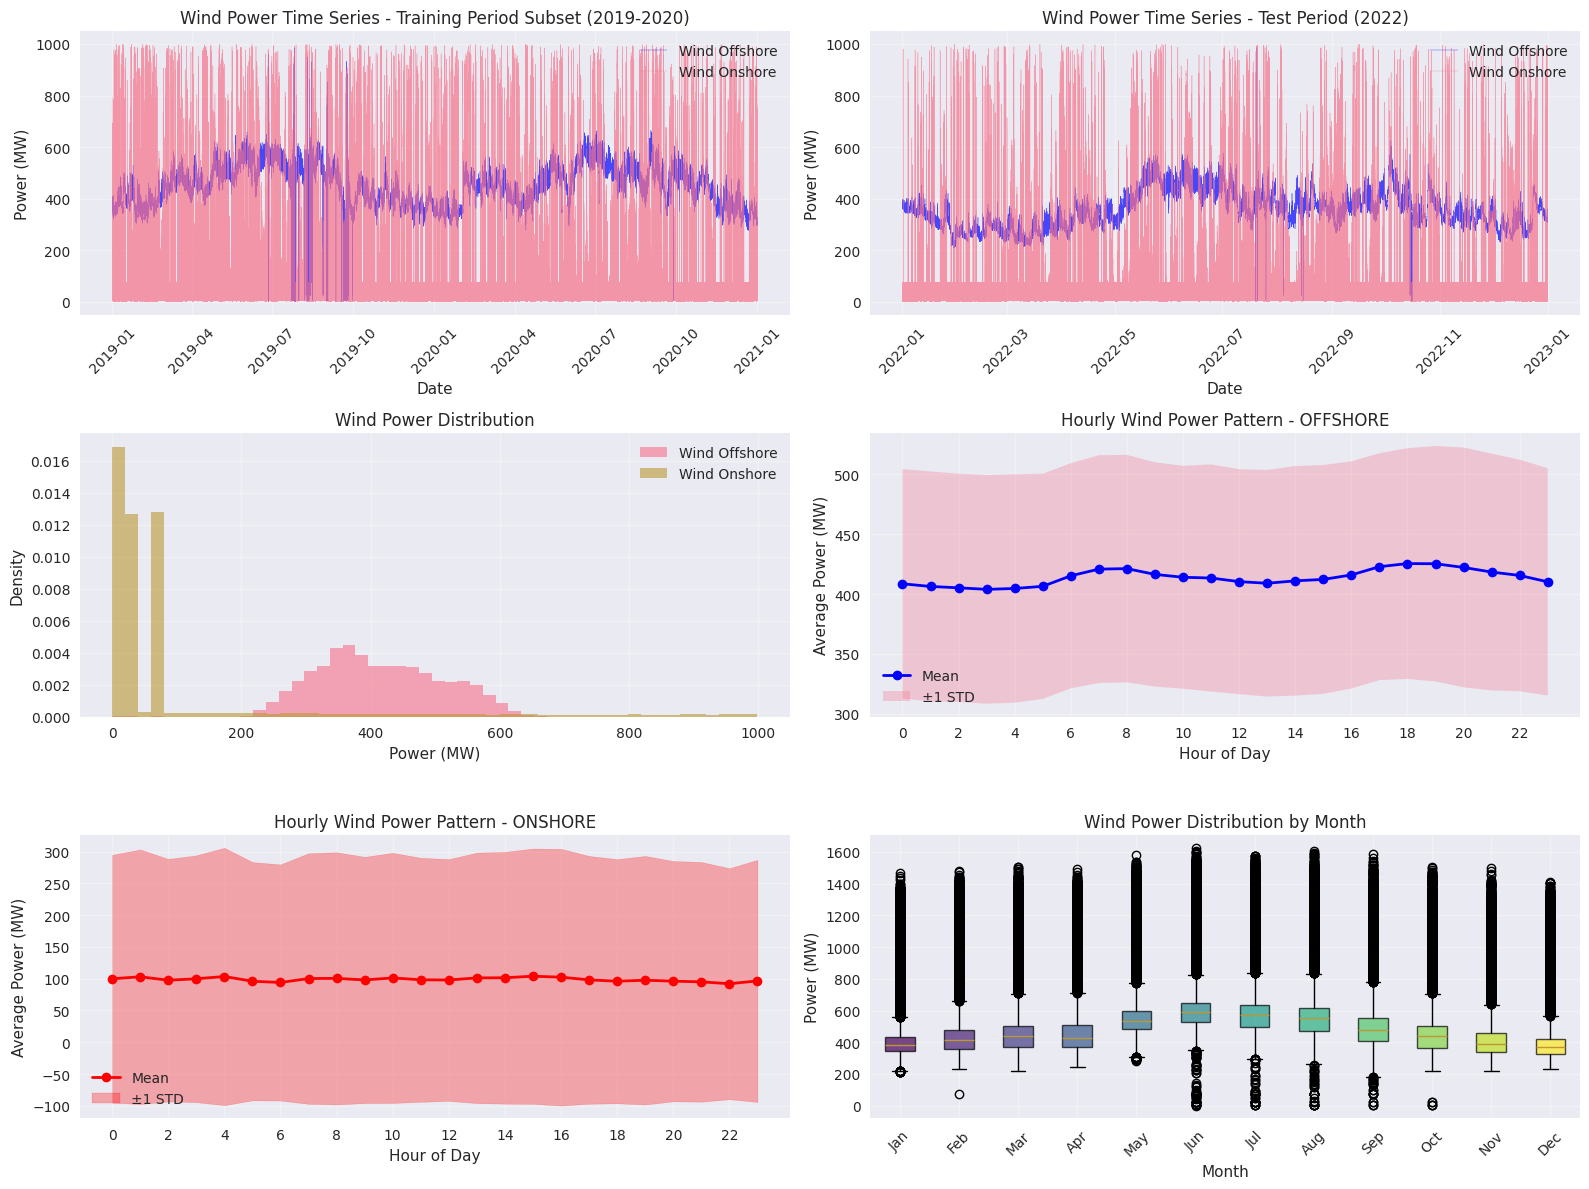



📊 DATA COMPLETENESS EXPLANATION

📊 Completeness Statistics:
  Mean daily completeness: 100.00%
  Minimum daily completeness: 95.83%
  Days with <100% completeness: 4
  Days with <90% completeness: 0


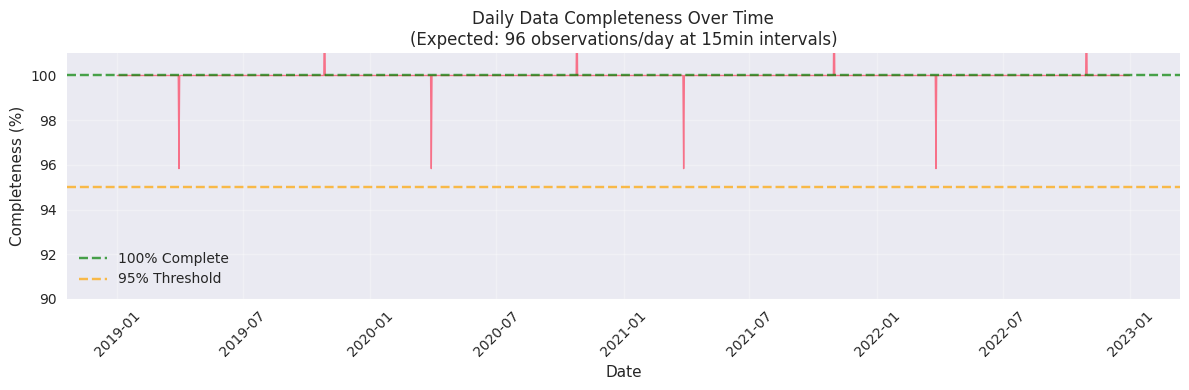


🔍 WIND POWER RELATIONSHIP ANALYSIS
📊 Correlation Analysis:
  Pearson correlation: 0.0067


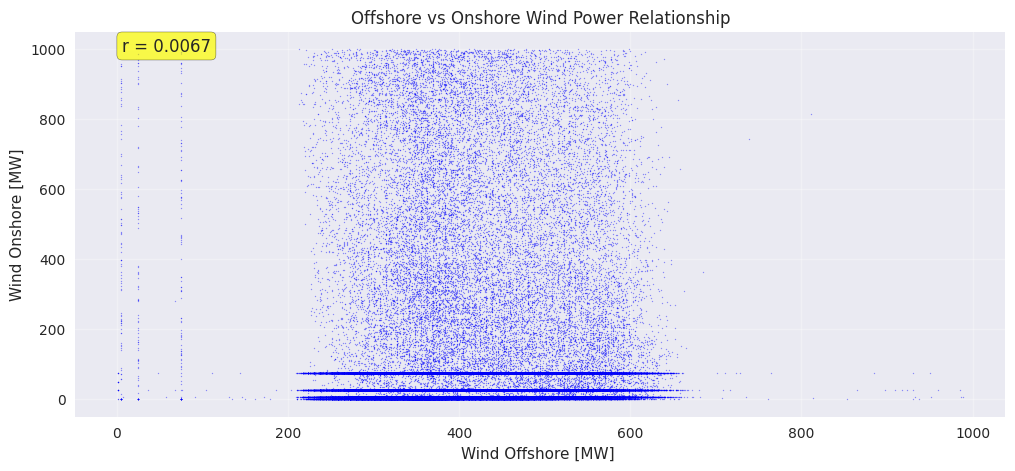

In [23]:
# Looking at wind power generation data first
from plot_utils import wind_data_summary, create_wind_eda_plots, explain_data_completeness, wind_scatter_analysis

df = pd.read_csv(DATASET_PATH)
df_processed = wind_data_summary(df)
create_wind_eda_plots(df_processed)
completeness = explain_data_completeness(df_processed)
wind_correlation = wind_scatter_analysis(df_processed)

**Findings:**  

Wind Offshore: Relatively consistent (Coefficient of Variation = 0.23), stable baseline ~414 MW, no missing values  

Wind Onshore: Extremely variable (Coefficient of Variation = 1.96), low baseline ~99 MW, highly irregular

Consider forecasting them separately then summing, rather than forecasting the total directly. Offshore wind is the dominant, predictable component while onshore is the volatile component.

Consider robust scaling especially for onshore wind to handle the extreme right skew

Potentially doing something about DST irregularities? (1) fill gaps, 2) convert to UTC?

Seasonalities: If any you could argue for a yearly seasonality with slightly higher generations in summer than in winter 

#### 🌤️ Weather Data Description


| **Column**         | **Description**                                                                 | **Usage for TTM**                                           |
|--------------------|----------------------------------------------------------------------------------|--------------------------------------------------------------|
| `longitude`, `latitude` | Geographical coordinates of the forecast grid point                        | Use for **spatial alignment** or **interpolation** to plant |
| `forecast_origin`   | Time when the forecast was issued                                               | Use to determine **forecast lead time**                     |
| `time`              | Valid time of the forecast (i.e., when the forecast applies)                    | Align with **target wind power timestamp**                  |
| `cdir`              | Cardinal wind direction (°)                                                     | Optional directional feature                                |
| `z`                 | Geopotential height                                                             | Rarely needed for power; may relate to elevation effects    |
| `msl`               | Mean sea level pressure (hPa)                                                   | Could help model pressure-driven wind patterns              |
| `blh`               | Boundary layer height                                                           | Indicates turbulence layer; optional                        |
| `tcc`               | Total cloud cover (0–1)                                                         | Useful proxy for sunlight → solar gain interference         |
| `u10`, `v10`        | 10m wind speed, u-component (east-west), v-component (north-south) (m/s)                                                       | **Primary feature** for wind power                          |
| `t2m`               | Temperature at 2 meters (K)                                                     | Optional; affects air density                               |
| `ssr`, `tsr`, `sund`| Surface/Top solar radiation & sunshine duration                                 | Optional; mostly for solar models                           |
| `tp`                | Total precipitation                                                             | Might relate to wind instability                            |
| `fsr`               | Forecast solar radiation                                                        | See above                                                   |
| `u100`, `v100`      | 100m wind components (m/s), u-component (east-west), v-component (north-south)                                                      | **Highly relevant** — turbines operate around this height   |


🗺️ CREATING REAL MAP VISUALIZATION
📍 Processing 80 unique grid points


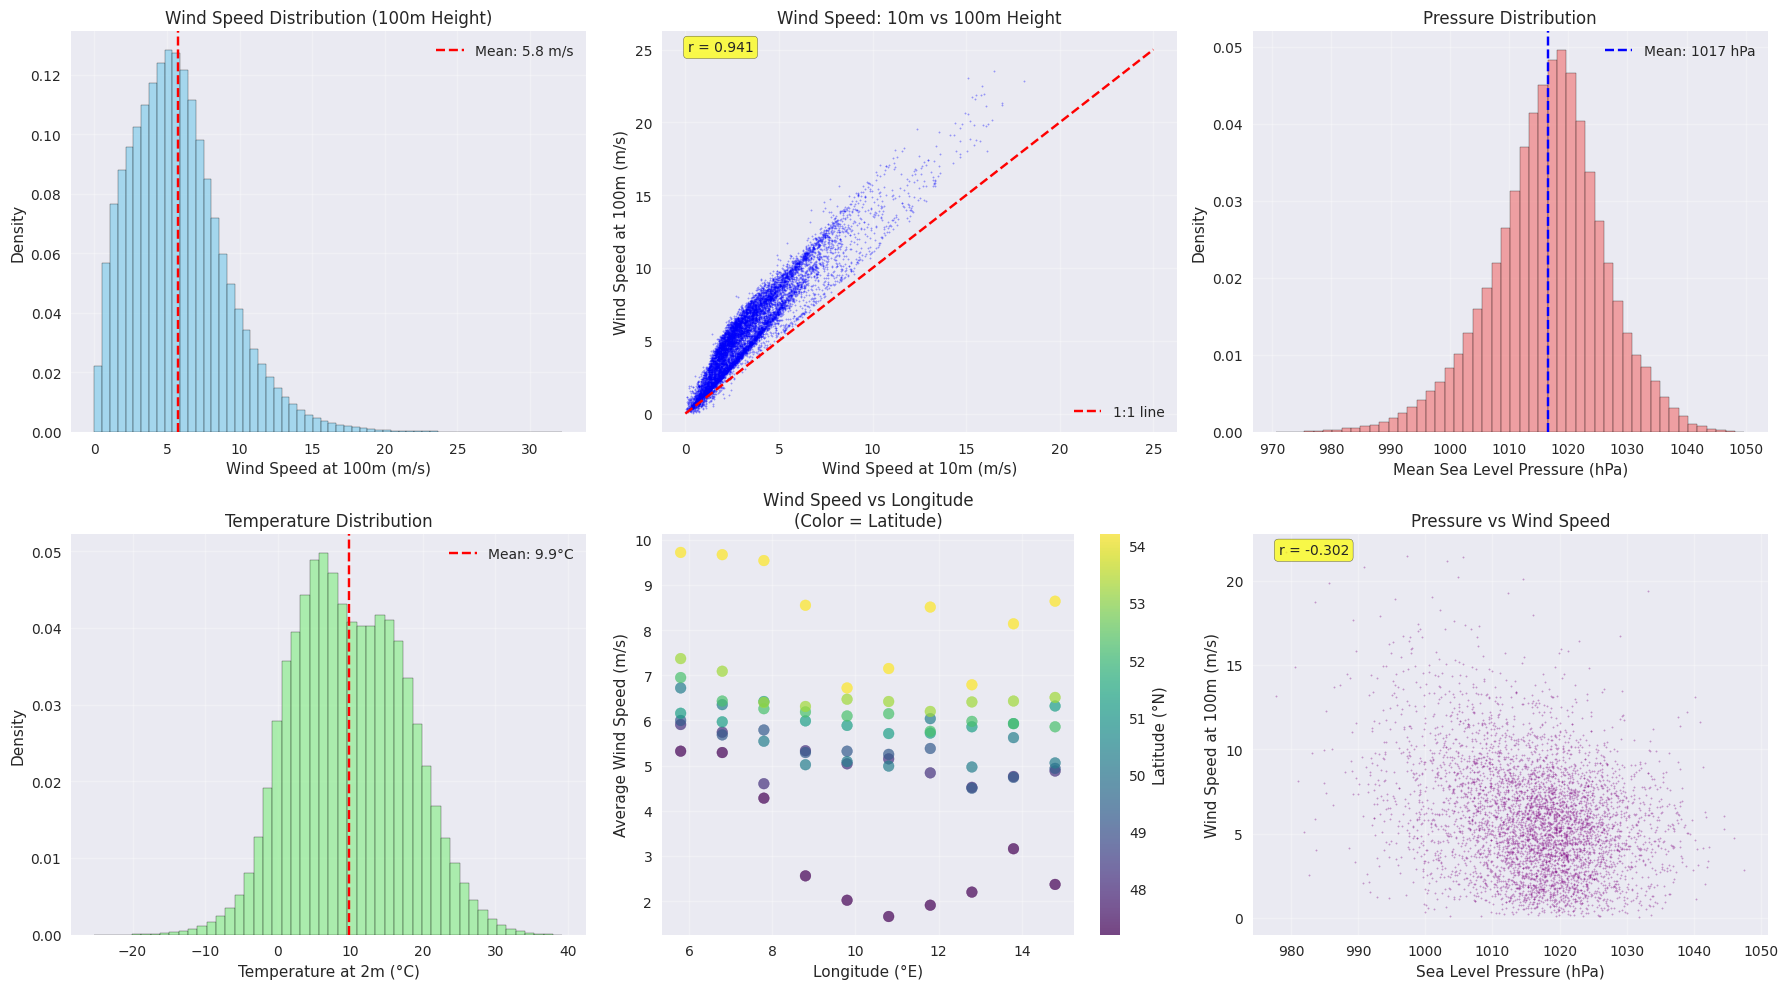


🌍 GEOGRAPHIC ANALYSIS SUMMARY
📊 Grid Coverage:
  Total weather stations: 80
  Longitude span: 5.80° to 14.80°
  Latitude span: 47.20° to 54.20°
  Data records per station: 35,064 to 35,064

🌊 Coastal vs Inland Wind Analysis:
  Coastal stations (lat ≥ 53.5°): 10
  Inland stations (lat < 53.5°): 70
  Average coastal wind (100m): 8.34 m/s
  Average inland wind (100m): 5.39 m/s
  Coastal wind advantage: 54.9%

🌪️ Top Wind Resource Locations:
  9.72 m/s at (54.20°N, 5.80°E)
  9.67 m/s at (54.20°N, 6.80°E)
  9.54 m/s at (54.20°N, 7.80°E)


In [24]:
from plot_utils import plot_weather_on_real_map, create_interactive_wind_analysis
coord_analysis = plot_weather_on_real_map(weather)
interactive_map = create_interactive_wind_analysis(coord_analysis)

**Findings**:  
-> Clear north-south wind resource gradient, consider different spatial aggregation strategies
-> Lower pressure = higher winds (weather systems)  
-> 10m + 100m wind strongly correlate, might be redundant to use both  

### Data Processing - ETL

The method **prepare_wind_power_dataset** loads the wind power and weather datasets, applies preprocessing (e.g. unifying temporal resolution, scaling), executes feature processing (e.g. spatial aggregation, temporal features, lag features) and splits the dataset into train, validation and test set.

In [25]:
df_wind = df.copy()
df_weather = weather.copy()
result = prepare_wind_power_dataset(df_wind, df_weather, spatial_config=SPATIAL_CONFIG, context_length=CONTEXT_LENGTH, prediction_length=PREDICTION_LENGTH, verbose=False)

df_combined = result['data']
tsp = result['preprocessor']
split_config = result['split_config']
column_specifiers = result['column_specifiers']
context_length = result['context_length']  # Should match CONTEXT_LENGTH
prediction_length = result['prediction_length']  # Should match PREDICTION_LENGTH

=== WIND POWER TTM DATA PREPARATION PIPELINE ===

Step 1: Cleaning and resampling wind power data (15min -> hourly)
Step 2: Creating weather features with configurable resolution
=== Creating weather features (spatial_config: simple) ===
Creating derived features: wind_speed_10m, wind_speed_100m
Spatial strategy: Simple averaging across all 80 stations
Final weather feature set: (35064, 18)
Feature columns: 17
Step 3: Merging datasets
Step 4: Creating temporal splits
Step 5: Setting up TTM preprocessor

PIPELINE COMPLETE


### Feature Selection

We conducted feature selection through a hybrid approach: We first pursue a **preselection** by creating multiple feature categories. Our **base features** consisted of core meteorological variables including wind information, temperature, pressure, and other weather parameters. We then enhanced this foundation by adding **temporal features** that capture time-based patterns and seasonality indicators, **derived features** through mathematical transformations and combinations of base features, **lag features** representing historical values from previous time steps, and multi-resolution features with different **spatial aggregations strategies**.  
Given weather data from 80 locations across Germany, we tested three spatial aggregation strategies. The *'simple'* approach averaged values across all locations, while *'coastal/inland'* created separate feature columns for coastal versus inland regions. The *'latitude_bands'* strategy maintained distinct features for different latitude zones. Validation set performance comparison allowed us to eliminate underperforming feature categories, specifically temporal features, lag features, and the latitude_bands strategy. However, differences between the remaining options were not statistically significant, creating ambiguity in our final selection.

To resolve these remaining ambiguities, we applied **permutation importance** analysis. Our methodology involved running model evaluation multiple times for each feature: once with original feature values to establish baseline performance, and once with randomly shuffled feature values. The importance was calculated as the performance difference between intact versus shuffled features.  

**Feature Pruning Algorithm:**

```text
Repeat the following steps:

1. Train the model with the current feature set
2. Use the trained model to evaluate ALL features (no retraining needed)
3. Remove up to 2 features with the most negative importance scores
4. Retrain the model with the reduced feature set
5. Repeat until all remaining features have importance ≥ 0
```
Note: Apply separately for onshore and offshore target variables

The interpretation is straightforward: when performance degraded after shuffling, the feature contributed predictive power and should be retained. Conversely, when performance improved after shuffling, the feature added noise and should be removed. This rigorous two-stage process ultimately yielded our final optimized feature set:



![permutation_importance_schematic](images/permutation_importance_schematic.png)


Taken from:  Chen, H. et al. (2023). Revolutionizing infection risk scoring: An ensemble “from weak to strong” deduction strategy and enhanced point‐of‐care testing tools. Advanced Intelligent Systems, 5(11), 2300224. https://doi.org/10.1002/aisy.202300224



### Zero-Shot Evaluation

**run_wind_power_experiment** loads the data processed as described before, runs training with early stopping and evaluates model performance or conducts evaluation of zero-shot method when specified.

In [26]:
# For demonstration purposes, take all reasonable weather features 
feature_config = {
    'base_features': ['u100','v100','u10','v10','msl','t2m','cdir','blh','tcc','tp'],
    'derived_features': True, # add feature transformations
    'temporal_features': False, # no explicit temporal features
    'lag_features': [] # no lag features
}

In [27]:
# Run zero-shot evaluation WITHOUT exogenous variables 
eval_results = run_wind_power_experiment(
    spatial_config="simple", # How to treat weather data points from different locations
    eval_split="valid", # use validation set for evaluation
    dataset_path=DATASET_PATH,
    weather_path=WEATHER_PATH,
    weather_path_2=WEATHER_PATH_2,
    model_type="zero-shot",
    context_length=context_length,
    prediction_length=prediction_length,
    num_epochs=NUM_EPOCHS,  
    batch_size=BATCH_SIZE,
    seed=SEED,
    feature_config=feature_config,
    save_results=False,
    use_exog=False
)

zs_without_exo_mae_offshore = eval_results['metrics']['wind_power_offshore']['overall']['mae']
zs_without_exo_mae_onshore = eval_results['metrics']['wind_power_onshore']['overall']['mae']

🔧 EXPERIMENT_RUNNER: Calling prepare_wind_power_dataset with shuffle_feature='None'
=== WIND POWER TTM DATA PREPARATION PIPELINE ===

Step 1: Cleaning and resampling wind power data (15min -> hourly)
Step 2: Creating weather features with configurable resolution
=== Creating weather features (spatial_config: simple) ===
Creating derived features: wind_speed_10m, wind_speed_100m
Spatial strategy: Simple averaging across all 80 stations


INFO:p-2373938:t-140385765553984:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


Final weather feature set: (35064, 18)
Feature columns: 17
Step 3: Merging datasets
Step 4: Creating temporal splits
Step 5: Setting up TTM preprocessor

PIPELINE COMPLETE
Running zero-shot experiment - simple spatial - 19 features
🆕 Loading new model from checkpoint


INFO:p-2373938:t-140385765553984:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 512-48-ft-r2.1.
INFO:p-2373938:t-140385765553984:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 48
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


📊 EXPERIMENT_RUNNER: Using zero-shot model (skipping training)


🔍 EXTRACTING EXPERIMENT METADATA

🔧 PREPARING EVALUATION DATA
------------------------------

COMPUTING MULTI-HORIZON METRICS
----------------------------------------

  wind_power_offshore:
    Overall: MAE=  43.2 MW, RMSE=  63.0 MW

  wind_power_onshore:
    Overall: MAE=  81.1 MW, RMSE= 115.4 MW

✅ Evaluation complete:
   Targets evaluated: ['wind_power_offshore', 'wind_power_onshore']
   Horizons per target: 24


In [28]:
# Run zero-shot evaluation WITH exogenous variables 
eval_results = run_wind_power_experiment(
    spatial_config="simple", # How to treat weather data points from different locations
    eval_split="valid", # use validation set for evaluation
    dataset_path=DATASET_PATH,
    weather_path=WEATHER_PATH,
    weather_path_2=WEATHER_PATH_2,
    model_type="zero-shot",
    context_length=context_length,
    prediction_length=prediction_length,
    num_epochs=NUM_EPOCHS,  
    batch_size=BATCH_SIZE,
    seed=SEED,
    feature_config=feature_config,
    save_results=False,
    use_exog=True # Activate mixing with exogenous variables
)

🔧 EXPERIMENT_RUNNER: Calling prepare_wind_power_dataset with shuffle_feature='None'
=== WIND POWER TTM DATA PREPARATION PIPELINE ===

Step 1: Cleaning and resampling wind power data (15min -> hourly)
Step 2: Creating weather features with configurable resolution
=== Creating weather features (spatial_config: simple) ===
Creating derived features: wind_speed_10m, wind_speed_100m
Spatial strategy: Simple averaging across all 80 stations


INFO:p-2373938:t-140385765553984:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


Final weather feature set: (35064, 18)
Feature columns: 17
Step 3: Merging datasets
Step 4: Creating temporal splits
Step 5: Setting up TTM preprocessor

PIPELINE COMPLETE
Running zero-shot experiment - simple spatial - 19 features
🆕 Loading new model from checkpoint


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

📊 EXPERIMENT_RUNNER: Using zero-shot model (skipping training)


🔍 EXTRACTING EXPERIMENT METADATA

🔧 PREPARING EVALUATION DATA
------------------------------

COMPUTING MULTI-HORIZON METRICS
----------------------------------------

  wind_power_offshore:
    Overall: MAE=  56.6 MW, RMSE=  74.6 MW

  wind_power_onshore:
    Overall: MAE= 112.9 MW, RMSE= 160.2 MW

✅ Evaluation complete:
   Targets evaluated: ['wind_power_offshore', 'wind_power_onshore']
   Horizons per target: 24


In [29]:
zs_with_exo_mae_offshore = eval_results['metrics']['wind_power_offshore']['overall']['mae']
zs_with_exo_mae_onshore = eval_results['metrics']['wind_power_onshore']['overall']['mae']

### Finetuning

In [30]:
# compare against only taking wind speed:
feature_config_wind_speed = {
    'base_features': ['u100','v100','u10','v10'],
    'derived_features': False, # add feature transformations
    'temporal_features': False, # no explicit temporal features
    'lag_features': [] # no lag features
}

# Finetune WITH exogenous features
eval_results_wind_speed = run_wind_power_experiment(
    spatial_config="simple", # How to treat weather data points from different locations
    eval_split="valid", # use validation set for evaluation
    dataset_path=DATASET_PATH,
    weather_path=WEATHER_PATH,
    weather_path_2=WEATHER_PATH_2,
    model_type="finetuned",
    context_length=context_length,
    prediction_length=prediction_length,
    num_epochs=NUM_EPOCHS,  
    batch_size=BATCH_SIZE,
    seed=SEED,
    feature_config=feature_config_wind_speed,
    save_results=False,
    use_exog=True
)

finetuned_windspeed_mae_offshore = eval_results_wind_speed['metrics']['wind_power_offshore']['overall']['mae']
finetuned_windspeed_mae_onshore = eval_results_wind_speed['metrics']['wind_power_onshore']['overall']['mae']

🔧 EXPERIMENT_RUNNER: Calling prepare_wind_power_dataset with shuffle_feature='None'
=== WIND POWER TTM DATA PREPARATION PIPELINE ===

Step 1: Cleaning and resampling wind power data (15min -> hourly)
Step 2: Creating weather features with configurable resolution
=== Creating weather features (spatial_config: simple) ===


INFO:p-2373938:t-140385765553984:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


Spatial strategy: Simple averaging across all 80 stations
Final weather feature set: (35064, 6)
Feature columns: 5
Step 3: Merging datasets
Step 4: Creating temporal splits
Step 5: Setting up TTM preprocessor

PIPELINE COMPLETE
Running finetuned experiment - simple spatial - 7 features
🆕 Loading new model from checkpoint


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Number of params before freezing backbone 803732
Number of params after freezing the backbone 250794


Epoch,Training Loss,Validation Loss
1,0.874700,0.802722
2,0.760700,0.788728
3,0.730300,0.774699
4,0.711400,0.761562
5,0.695100,0.741891
6,0.679200,0.718172
7,0.668800,0.712960
8,0.658600,0.711469
9,0.650400,0.716206
10,0.641000,0.713101


[TrackingCallback] Mean Epoch Time = 5.15569204550523 seconds, Total Train Time = 89.83323740959167
✅ Training completed! Final loss: 0.6874


🔍 EXTRACTING EXPERIMENT METADATA

🔧 PREPARING EVALUATION DATA
------------------------------

COMPUTING MULTI-HORIZON METRICS
----------------------------------------

  wind_power_offshore:
    Overall: MAE=  37.7 MW, RMSE=  55.8 MW

  wind_power_onshore:
    Overall: MAE=  80.0 MW, RMSE= 113.6 MW

✅ Evaluation complete:
   Targets evaluated: ['wind_power_offshore', 'wind_power_onshore']
   Horizons per target: 24


In [ ]:
# Finetune WITHOUT exogenous features
eval_results = run_wind_power_experiment(
    spatial_config="simple", # How to treat weather data points from different locations
    eval_split="valid", # use validation set for evaluation
    dataset_path=DATASET_PATH,
    weather_path=WEATHER_PATH,
    weather_path_2=WEATHER_PATH_2,
    model_type="finetuned",
    context_length=context_length,
    prediction_length=prediction_length,
    num_epochs=NUM_EPOCHS,  
    batch_size=BATCH_SIZE,
    seed=SEED,
    feature_config=feature_config,
    save_results=False,
    use_exog=False
)

🔧 EXPERIMENT_RUNNER: Calling prepare_wind_power_dataset with shuffle_feature='None'
=== WIND POWER TTM DATA PREPARATION PIPELINE ===

Step 1: Cleaning and resampling wind power data (15min -> hourly)
Step 2: Creating weather features with configurable resolution
=== Creating weather features (spatial_config: simple) ===
Creating derived features: wind_speed_10m, wind_speed_100m
Spatial strategy: Simple averaging across all 80 stations


INFO:p-2373938:t-140385765553984:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


Final weather feature set: (35064, 18)
Feature columns: 17
Step 3: Merging datasets
Step 4: Creating temporal splits
Step 5: Setting up TTM preprocessor

PIPELINE COMPLETE
Running finetuned experiment - simple spatial - 19 features
🆕 Loading new model from checkpoint


INFO:p-2373938:t-140385765553984:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 512-48-ft-r2.1.
INFO:p-2373938:t-140385765553984:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 48
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Number of params before freezing backbone 799756
Number of params after freezing the backbone 246818


Epoch,Training Loss,Validation Loss
1,0.340600,0.322986
2,0.330600,0.318840


In [ ]:
trained_model = eval_results["trained_model"]
finetuned_without_exo_mae_offshore = eval_results['metrics']['wind_power_offshore']['overall']['mae']
finetuned_without_exo_mae_onshore = eval_results['metrics']['wind_power_onshore']['overall']['mae']

In [ ]:
# Finetune WITH exogenous features
eval_results = run_wind_power_experiment(
    spatial_config="simple", # How to treat weather data points from different locations
    eval_split="valid", # use validation set for evaluation
    dataset_path=DATASET_PATH,
    weather_path=WEATHER_PATH,
    weather_path_2=WEATHER_PATH_2,
    model_type="finetuned",
    context_length=context_length,
    prediction_length=prediction_length,
    num_epochs=NUM_EPOCHS,  
    batch_size=BATCH_SIZE,
    seed=SEED,
    feature_config=feature_config,
    save_results=False,
    use_exog=True
)

In [ ]:
trained_model = eval_results["trained_model"]
trainer = eval_results["trainer"]

finetuned_with_exo_mae_offshore = eval_results['metrics']['wind_power_offshore']['overall']['mae']
finetuned_with_exo_mae_onshore = eval_results['metrics']['wind_power_onshore']['overall']['mae']

In [ ]:
# Define column widths for alignment
config_width = 40
mae_width = 12

# Print table header
print(f"{'Model Configuration':<{config_width}} | {'Offshore MAE':<{mae_width}} | {'Onshore MAE':<{mae_width}}")
print('-' * config_width + '-+-' + '-' * mae_width + '-+-' + '-' * mae_width)

# Print table rows
print(f"{'Zero-shot without Exogenous':<{config_width}} | {zs_without_exo_mae_offshore:<{mae_width}.3f} | {zs_without_exo_mae_onshore:<{mae_width}.3f}")
print(f"{'Zero-shot with Exogenous':<{config_width}} | {zs_with_exo_mae_offshore:<{mae_width}.3f} | {zs_with_exo_mae_onshore:<{mae_width}.3f}")
print(f"{'Fine-tuned without Exogenous':<{config_width}} | {finetuned_without_exo_mae_offshore:<{mae_width}.3f} | {finetuned_without_exo_mae_onshore:<{mae_width}.3f}")
print(f"{'Fine-tuned with Exogenous':<{config_width}} | {finetuned_with_exo_mae_offshore:<{mae_width}.3f} | {finetuned_with_exo_mae_onshore:<{mae_width}.3f}")
print(f"{'Fine-tuned Wind Speed with Exogenous':<{config_width}} | {finetuned_windspeed_mae_offshore:<{mae_width}} | {finetuned_windspeed_exo_mae_onshore:<{mae_width}.3f}")

### TTM Model Insights & Explainability: Importance Weights of Gated Attention Mechanism

The channel mixing layers in TTM's decoder use **gated attention**:

$$
\text{attention\_weights} = \text{softmax}(\text{Linear}(\text{input}))
$$

Then,

$$
\text{output} = \text{attention\_weights} \times \text{input}
$$

We hook into these softmax weights to capture how much each of the 19 input channels gets "gated" or emphasized. We extract attention weights from decoder layers and aggregate across batches and patches/hidden dimensions, resulting in a $[200 \text{ samples} \times 19 \text{ channels}]$ matrix showing channel importance across different predictions.


In [ ]:
import channel_attention_map as cam
# Make sure finetuned model is accessible 
# and load eval dataset (=validation set)
dset_train, dset_valid, dset_test = get_datasets(
    tsp, df_combined, split_config, 
    use_frequency_token=trained_model.config.resolution_prefix_tuning
)

eval_dataset = dset_valid

attention_weights, attention_matrix, results_df, cross_results = cam.main_analysis_pipeline(
    trained_model, trainer, eval_dataset, tsp, include_cross_channel=True
)

The attention weights are extracted from decoder channel mixer layers, where gated attention applies softmax(Linear(input)) across channels to determine how much each channel gets emphasized. The heatmap shows attention patterns across multiple prediction samples, revealing that target variables wind_power_onshore (0.065) and wind_power_offshore (0.061) receive the highest attention, indicating strong autoregressive learning where the model heavily relies on historical target values. Among weather variables, surface winds (v10: 0.063) and high-altitude measurements (wind_speed_100m, pressure_hpa) show elevated attention, while auxiliary features like forecast_lead_hours and boundary layer height (blh) receive lower weights, suggesting the model has learned to focus on meteorologically relevant features for wind power prediction.

The cross-channel attention maps show the relationship between target variable attention and exogenous weather variable attention, computed by analyzing attention patterns when target attention is high versus overall patterns. The relative importance plot shows how much weather variables are attended when target attention is elevated. The key finding is that both offshore and onshore wind power predictions exhibit nearly identical attention patterns to weather variables, indicating that both targets rely on similar meteorological inputs.

### Results

The final evaluation results on the test set as well as the details of the feature selection results are embedded in a separate streamlit app

### Discussion

Tiny Time Mixers handle multivariate time series, exogenous variables (e.g., weather data), and static variables effectively, making them versatile for time series forecasting. They show strong zero-shot performance, especially for offshore predictions and short horizons, enabling quick deployment without extensive fine-tuning. With a lightweight architecture (~1M parameters), TTM is efficient for a foundation model, supporting fast fine-tuning and batch predictions.  Additionally, the importance weights through the gated attention mechanism provide inherent explainability.

Nevertheless, TTM lacks thorough documentation and examples, complicating implementation. For instance, enabling exogenous variables required specific flags, causing initial oversight and a steep learning curve. Fine-tuning yields minimal performance gains, limiting its value. As a data-driven model, TTM may miss complex physical phenomena (e.g., meteorological interactions) better captured by physical or hybrid models. Its diverse training data covers a rich set of different time series datasets, which raises the question regarding its domain-specific performance in comparison to other time series models, e.g. against XGBoost. GPU requirements for finetuning and fast predictions may also constrain accessibility.

I would consider using TTM for time series forecasting when multivariate modeling, exogenous variable integration, and quick zero-shot predictions are priorities, and computational resources are limited. Avoid TTM when ease of use, robust documentation, or precise modeling of physical phenomena are critical, as halternatives like XGBoost may perform better, pending further evaluation.